# Projeto de Arquitetura de Dados Distribuídos e Particionados

# 1. Aquisição de dados

A primera tarefa a ser realizada é a obtenção da base de dados do Cadastro Ambienteal Rural (CAR) com os campos das características ambientais das propriedades rurais de todo o Brasil. Estes dados estão disponibilizados no site do Ministério da Agricultura em formato CSV.

Como o arquivo possui 2 GB, é obtido primeiro um arquivo parcial (1.1) e, posteriormente, o conjunto de dados completo (1.3).

<br>

**Tarefas**

1. Download parcial do arquivo
2. Persistência dos dados: Movimentação do arquivo do Driver para o DBFS
3. Repetir etapa 1 e 2 para obter a base de dados completa

## 1.1 Download parcial do arquivo

Como estratégia para manipular um arquivo de menor dimensão na etapa de desenvolvimento da solução, o download dos dados é limitado em 100 Mb, obtendo uma base parcial, com a parte inicial do arquivo.

In [0]:
%sh
# Remoção dos dados anteriores
rm -f ./temas_ambientais_fragmento.csv

# Variável do caminho web do arquivo
file_web_uri=https://dados.agricultura.gov.br/dataset/58bdc09c-9778-42b9-8fce-7d5c2c4fa211/resource/daf8053b-5446-4cd4-986a-f141b4a434ec/download/temas_ambientais.csv

# Limitação do download (Mb)
(ulimit -f 102400; wget -O temas_ambientais_fragmento_100mb.csv $file_web_uri )

--2023-11-22 00:50:46--  https://dados.agricultura.gov.br/dataset/58bdc09c-9778-42b9-8fce-7d5c2c4fa211/resource/daf8053b-5446-4cd4-986a-f141b4a434ec/download/temas_ambientais.csv
Resolving dados.agricultura.gov.br (dados.agricultura.gov.br)... 201.57.198.178
Connecting to dados.agricultura.gov.br (dados.agricultura.gov.br)|201.57.198.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2172058463 (2.0G) [text/csv]
Saving to: ‘temas_ambientais_fragmento_100mb.csv’

     0K .......... .......... .......... .......... ..........  0%  123K 4h48m
    50K .......... .......... .......... .......... ..........  0%  122K 4h48m
   100K .......... .......... .......... .......... ..........  0%  200K 4h11m
   150K .......... .......... .......... .......... ..........  0%  244K 3h44m
   200K .......... .......... .......... .......... ..........  0%  245K 3h28m
   250K .......... .......... .......... .......... ..........  0%  313K 3h12m
   300K .......... .......... ..

## 1.2 Persistência dos dados: Movimentação do arquivo do Driver para o DBFS

Os arquivos baixados são salvos no armazenamento em driver do Databricks, que não é mantido na reinicialização do cluster. Para que sejam permanentes é preciso colocá-los no DBFS.

In [0]:
# Verificação dos arquivos na pasta raiz de download do driver
display( dbutils.fs.ls('file:/databricks/driver') )

path name size modificationTime file:/databricks/driver/azure/ azure/ 4096 1700547727591 file:/databricks/driver/conf/ conf/ 4096 1700547726559 file:/databricks/driver/preload_class.lst preload_class.lst 1306936 1700547727651 file:/databricks/driver/hadoop_accessed_config.lst hadoop_accessed_config.lst 2755 1700547727631 file:/databricks/driver/eventlogs/ eventlogs/ 4096 1700613914951 file:/databricks/driver/metastore_db/ metastore_db/ 4096 1700614103525 file:/databricks/driver/logs/ logs/ 4096 1700614114873 file:/databricks/driver/ganglia/ ganglia/ 4096 1700613906375 file:/databricks/driver/temas_ambientais_fragmento_100mb.csv temas_ambientais_fragmento_100mb.csv 104857600 1700614414508

In [0]:
# Copia de arquivo para o DBFS
dbutils.fs.cp(
    'file:/databricks/driver/temas_ambientais_fragmento_100mb.csv', 
    'dbfs:/FileStore/modulo_big_data/temas_ambientais_fragmento_100mb.csv')

## 1.3 Obtenção da base completa

Processo semelhante às etapas anteriores é usado para obtenção da base de dados completa.

In [0]:
%sh
# Remoção dos dados anteriores
rm -f ./temas_ambientais.csv

# Variável do caminho web do arquivo
file_web_uri=https://dados.agricultura.gov.br/dataset/58bdc09c-9778-42b9-8fce-7d5c2c4fa211/resource/daf8053b-5446-4cd4-986a-f141b4a434ec/download/temas_ambientais.csv

# Download completo
wget $file_web_uri

# Copia de arquivo para o DBFS
dbutils.fs.cp(
    'file:/databricks/driver/temas_ambientais.csv', 
    'dbfs:/FileStore/modulo_big_data/temas_ambientais.csv')

# Aviso de conclusão
print('Arquivo baixado e salvo com sucesso!')

# 2. Estrutura dos dados

### 2.1 Verificação dos dados

Com os arquivos baixados, a próxima tarefa é entender melhor os dados que foram disponibilizados. O próprio produtor dos dados disponibiliza um metadado com algumas informações sobre ele, mas não suficientes para a construção correta da solução de arquitetura de big data.

Para compreender a estrutura dos dados, a parte inicial da amostra é acessada para conduzir a investigação.

In [0]:
print(dbutils.fs.head('dbfs:/FileStore/modulo_big_data/temas_ambientais_fragmento.csv'))

[Truncated to first 65536 bytes]
uf;municipio;codigo_ibge;area_do_imovel;registro_car;situacao_cadastro;condicao_cadastro;area_liquida;area_remanescente_vegetacao_nativa;area_reserva_legal_proposta;area_preservacao_permanente;area_nao_classificada;solicitacao_adesao_pra;latitude;longitude;data_inscricao;data_alteracao_condicao_cadastro;area_rural_consolidada;area_servidao_administrativa;tipo_imovel_rural;modulos_fiscais;area_uso_restrito;area_reserva_legal_averbada;area_reserva_legal_aprovada_nao_averbada;area_pousio;data_ultima_retificacao
GO;Nazário;5214408;119.6326;GO-5214408-3AEF2043582E40238C0F84A553686CA7;AT;Analisado com pendências, aguardando retificação e/ou apresentação de documentos;119.6326;6.43202795367569;6.4320;5.29751084282892;0.00102295610380904;Sim;-16.5923058689987;-49.9019017039191;2014-05-07 16:01:44.305;;112.301149046683;0;IRU;5.4378;0;0.0000;0.0000;0;2014-05-07 16:01:44.305
SC;Meleiro;4210803;7.5340;SC-4210803-BC127B0EC8DB49AC9D46D723286241A2;AT;Aguardando anális

## 2.2 Estrutura do Arquivo

* **ARQUIVO**
  * Formato: `CSV`
  * Separador: `;`
  * Decimal: `.`
* **COLUNA**
  * Case: `snake_case`
* **VALORES TEXTUAIS**
  * Caracteres Especiais: `True`

## 2.3 Dicionário de Dados

* Arquivo de descrição oficial do arquivo: https://dados.agricultura.gov.br/dataset/58bdc09c-9778-42b9-8fce-7d5c2c4fa211/resource/5434ae5e-18b9-45fc-9ad1-b82c56394e78/download/dicionario-temas-ambientais.pdf

* A unidade de medida de todas as áreas estão em `ha`.

# 3. Desenvolvimento da Arquitetura do Big Data

<br>

1. carrega a tabela e suas amostras
2. realiza consultas SQL
3. cria tabelas particionadas
4. realiza loop das consultas para obter dados estatísticos

In [0]:
# Importa pacotes
import pandas as pd
import numpy as np
import time
import pyspark.pandas as ps
import pyspark.sql.dataframe
from pyspark.sql.types import DateType
from pyspark.sql.functions import year

## 3.1 Carga dos Dados para o Spark

A estratégia para ingestão de dados no Hive utiliza o Spark para processar o conjunto de dados (*dataset*) armazenado no DBFS, sistema de armazenamento distribuído do ecosistema Hadoop implementado pelo Databricks. 

O arquivo armanezado é lido, transformado e carregado para dentro das tabelas Hive do Databricks. A leitura é uma simples operação de tabulação de um arquivo CSV. No tratamento uma nova coluna com extração do dado do ano foi obtida. Também ocorre a ordenação das colunas.

**Estratégia para o desenvolvimento**: por se tratar de uma base de grandes dimensões, o desenvolvimento contínuo e exploratório se tornar pouco eficiente devido ao tempo de espera para execução de cada tarefa. Desta maneira, para melhorar a fluidez do desenvolvimento do *data pipeline* foi implementado uma estratégia de utilização de amostras menores do arquivo. Com isso, primeiro foi usado um arquivo de 10 Mb para montar a estrutura do script. Depois com uma outra base de 100 Mb foi possível refinar a arquitetura desenvolvida já que está representa melhor a base final. Ao final foi usa a base completa e comparado os resultados entre as amostras.

In [0]:
# INGESTÃO DE CONJUNTO DE DADOS NO HIVE COM SPARK

# Leitura dos arquivos CSV em Spark dataframe
file_path_sample = 'dbfs:/FileStore/modulo_big_data/temas_ambientais_fragmento_100mb.csv'
file_path_total = 'dbfs:/FileStore/modulo_big_data/temas_ambientais.csv'

def leitura_arquivo_csv(filepath: str) -> pyspark.sql.dataframe.DataFrame:
    return (spark.read
                .option('delimiter', ';')
                .option('header', 'true')
                .csv(filepath))


df_spark_sample = leitura_arquivo_csv(file_path_sample)
df_spark_total = leitura_arquivo_csv(file_path_total)

In [0]:
# Tratamento simples da base de dados com pyspark
def trasformacao_dados(df: pyspark.sql.dataframe.DataFrame) -> pyspark.sql.dataframe.DataFrame:
    # Feature Engineering
    # Ano
    df_treat = df.withColumn('ano', year(df['data_inscricao'].cast(DateType())))

    # Ordenação das colunas
    df_treat = df_treat.select(['uf', 'municipio', 'codigo_ibge', 'registro_car', 'situacao_cadastro', 'condicao_cadastro', 'tipo_imovel_rural', 'area_do_imovel', 'modulos_fiscais', 'area_liquida', 'area_servidao_administrativa', 'area_remanescente_vegetacao_nativa', 'area_reserva_legal_proposta', 'area_preservacao_permanente', 'area_nao_classificada', 'solicitacao_adesao_pra', 'area_rural_consolidada', 'area_uso_restrito', 'area_reserva_legal_averbada', 'area_reserva_legal_aprovada_nao_averbada', 'area_pousio', 'data_ultima_retificacao', 'data_inscricao', 'data_alteracao_condicao_cadastro', 'ano', 'latitude', 'longitude'])

    return df_treat


# APLICAÇÃO DO TRATAMENTO
df_spark_treat_sample = trasformacao_dados(df_spark_sample)
df_spark_treat_total = trasformacao_dados(df_spark_total)

# VISUALIZAÇÃO DO NÚMERO DE LINHAS
print('Número de linhas da amostra:', df_spark_treat_sample.count())
print('Número de linhas da base toda:', df_spark_treat_total.count())

Número de linhas da amostra: 323947
Número de linhas da base toda: 6839104


## 3.2 Desenvolvimento das Consultas

Como o objetivo deste projeto é a construção de uma arquitetura de dados particionados em ambiente de big data (dados distribuídos), entender o propósito e a utilização destes dados é fundamental para melhor otimização orientada a este contexto. Então a próxima etapa é desenvolver algumas consultadas em SQL para resolver algumas perguntas sobre o comportamento dos terrenos rurais no Brasil, baseadas no Cadastro Ambietal Rural (CAR). Com a modelagem destas consultas é possível analisar quais são as possibilidades de particionamento mais adequadas.

<br>
As consultas previstas são: 

1. A soma de área (em hectares) para todas as propriedades agrícolas que pertencem ao MS e MT. Ordenadas em ordem decrescente.
2. Todas as propriedades que pertecem a região sudeste.
3. Quantas propriedades foram cadastradas por ano, apresentada em ordem cronológica.
4. Percentual médio de área remanescente de vegetação nativa em comparação a área total da propriedade.
5. Contagem de propriedades rurais por estado.
6. Média de área entre todas as propriedades. Contagem de quantas propriedades por estado estão acima da média.

In [0]:
# Persistência em tabela Hive de forma Monolítica

# 1. carrega amostra da tabela
(df_spark_treat_sample.write
    .option("header", True)
    .mode("overwrite")
    .saveAsTable("car_sample"))

In [0]:
%sql
SELECT * FROM car_sample LIMIT 15;

uf municipio codigo_ibge registro_car situacao_cadastro condicao_cadastro tipo_imovel_rural area_do_imovel modulos_fiscais area_liquida area_servidao_administrativa area_remanescente_vegetacao_nativa area_reserva_legal_proposta area_preservacao_permanente area_nao_classificada solicitacao_adesao_pra area_rural_consolidada area_uso_restrito area_reserva_legal_averbada area_reserva_legal_aprovada_nao_averbada area_pousio data_ultima_retificacao data_inscricao data_alteracao_condicao_cadastro ano latitude longitude GO Nazário 5214408 GO-5214408-3AEF2043582E40238C0F84A553686CA7 AT Analisado com pendências, aguardando retificação e/ou apresentação de documentos IRU 119.6326 5.4378 119.6326 0 6.43202795367569 6.4320 5.29751084282892 0.00102295610380904 Sim 112.301149046683 0 0.0000 0.0000 0 2014-05-07 16:01:44.305 2014-05-07 16:01:44.305 null 2014 -16.5923058689987 -49.9019017039191 SC Meleiro 4210803 SC-4210803-BC127B0EC8DB49AC9D46D723286241A2 AT Aguardando análise, não passível de revisão de dados IRU 7.5340 0.4186 7.5340 0 5.51785410336982 0.0000 0 0.00159349317984888 Nao 2.01445162492469 0 1.5060 0.0000 0 2014-05-07 16:02:02.915 2014-05-07 16:02:02.915 null 2014 -28.7930798512303 -49.6472023744097 GO Nova Roma 5214903 GO-5214903-7F58049BD79046E9A904CC81C5AC177A PE Analisado com pendências, aguardando retificação e/ou apresentação de documentos IRU 19.4883 0.2784 19.3600 0 19.4882633569717 3.8720 0 0 Nao 0 0 0.0000 0.0000 0 2014-05-07 16:06:15.777 2014-05-07 16:06:15.777 null 2014 -13.6370551503248 -47.0339670619739 GO Santa Helena de Goiás 5219308 GO-5219308-6478196E75CF4F65800ACA0758575820 PE Analisado com pendências, aguardando retificação IRU 22.9340 1.1467 22.8800 0 1.5021496193707 1.5028 0.568927694143718 18.2335997514784 Sim 3.08289042473435 0 0.0000 0.0000 0 2014-05-07 17:49:36.938 2014-05-07 17:49:36.938 null 2014 -17.8327877579625 -50.6015145422339 PR Cornélio Procópio 4106407 PR-4106407-0F06081500254BE3A479EE8EFFDD5319 AT Em análise IRU 10.9560 0.6087 10.9560 0 0 0.0000 0 0.161657419734154 Nao 10.7942669028953 0 0.0000 0.0000 0 2014-05-07 17:52:55.333 2014-05-07 17:52:55.333 null 2014 -23.1841101335722 -50.6715645967419 GO Buriti de Goiás 5203939 GO-5203939-24B66714683B47D1A96ED4AB5541A78D AT Analisado com pendências, aguardando retificação e/ou apresentação de documentos IRU 37.3628 1.6983 37.2710 0 0 7.4542 3.48182904076294 36.6495720619986 Sim 0 0 0.0000 0.0000 0 2014-05-07 18:10:09.195 2014-05-07 18:10:09.195 null 2014 -16.2164807816082 -50.4953581696022 GO Planaltina 5217609 GO-5217609-5AF3970F46CD4FF29FFDAC79F72610C1 PE Analisado com pendências, aguardando retificação e/ou apresentação de documentos IRU 97.9881 2.7997 98.1345 0 0 21.8673 2.12858352269074 97.6714521959102 Nao 0 0 0.0000 0.0000 0 2014-05-08 00:02:44.538 2014-05-08 00:02:44.538 null 2014 -15.1179720733421 -47.8383739460241 PR Jandaia do Sul 4112108 PR-4112108-9A8173321C6C49A8B4D12A5379ACD56B AT Aguardando análise, não passível de revisão de dados IRU 6.1533 0.3846 6.1533 0 0 0.0000 0 6.14899874393451 Sim 0 0 0.0000 0.0000 0 2014-05-08 08:00:36.973 2014-05-08 08:00:36.973 null 2014 -23.6224664264801 -51.6578666515836 PR Jandaia do Sul 4112108 PR-4112108-A5B59AF15D6642E4BCFBEEA253497168 AT Aguardando análise, não passível de revisão de dados IRU 4.9027 0.3064 4.9027 0 0 0.0000 0 4.89928986130661 Sim 0 0 0.0000 0.0000 0 2014-05-08 08:03:25.423 2014-05-08 08:03:25.423 null 2014 -23.6224240639671 -51.6578657246737 GO Formosa 5208004 GO-5208004-4F872D13349C49BE8C9120FF56C7434F PE Analisado com pendências, aguardando retificação e/ou apresentação de documentos IRU 5.4097 0.1352 5.4139 0 0 1.1026 2.27859310705466 1.21704276768816 Sim 3.76410267729312 0 0.0000 0.0000 1.21609669322065 2014-05-08 08:36:37.958 2014-05-08 08:36:37.958 null 2014 -15.5759058160859 -47.347320962841 GO Santa Helena de Goiás 5219308 GO-5219308-AF236397C7D44ED5847D48AF83555B2D PE Analisado com pendências, aguardando retificação e/ou apresentação de documentos IRU 3.9105 0.1955 3.9017 

In [0]:
# Teste das consultas com a amostra da tabela
nome_conj_dados = "car_sample"

# 1. A soma de área (em hectares) para todas as propriedades agrícolas que pertencem ao MS e MT. Ordenadas em ordem decrescente.
display(spark.sql(f"""
        SELECT 
            uf, 
            ROUND(SUM(CAST(area_do_imovel AS FLOAT))) AS soma_area_ha
        FROM 
            {nome_conj_dados}
        WHERE
            uf IN ('MS', 'MT')
        GROUP BY 
            uf;
    """))

# 2. Todas as propriedades que pertecem a região sudeste.
display(spark.sql(f"""
        SELECT 
            * 
        FROM 
            {nome_conj_dados} 
        WHERE 
            uf IN ('MG', 'RJ', 'ES', 'SP');
    """))

# 3. Quantas propriedades foram cadastradas por ano, apresentada em ordem cronológica.
display(spark.sql(f"""
        SELECT
            ano,
            COUNT(*) as qnt_propriedades
        FROM
            {nome_conj_dados}
        GROUP BY
            ano
        ORDER BY
            ano asc;
    """))

# 4. Percentual médio de área remanescente de vegetação nativa em comparação a área total da propriedade.
display(spark.sql(f"""
        SELECT 
            ROUND(MEAN(area_remanescente_vegetacao_nativa), 2) AS perc_medio_veg_nativa 
        FROM 
            {nome_conj_dados};
    """))

# 5. Contagem de propriedades rurais por estado.
display(spark.sql(f"""
        SELECT 
            uf, 
            COUNT(*) AS qnt_prop_rurais
        FROM 
            {nome_conj_dados} 
        GROUP BY 
            uf;
    """))

# 6. Média de área entre todas as propriedades. Contagem de quantas propriedades por estado estão acima da média.
display(spark.sql(f"""
        SELECT 
            uf,
            ROUND((SELECT MEAN(area_do_imovel) FROM {nome_conj_dados}), 2) AS area_media,
            COUNT(*) AS qnt_prop_rural_acima_da_media
        FROM 
            {nome_conj_dados} 
        WHERE 
            area_do_imovel > (SELECT MEAN(area_do_imovel) FROM {nome_conj_dados})
        GROUP BY 
            uf;
    """))



uf soma_area_ha MT 1.1404558E7

uf municipio codigo_ibge registro_car situacao_cadastro condicao_cadastro tipo_imovel_rural area_do_imovel modulos_fiscais area_liquida area_servidao_administrativa area_remanescente_vegetacao_nativa area_reserva_legal_proposta area_preservacao_permanente area_nao_classificada solicitacao_adesao_pra area_rural_consolidada area_uso_restrito area_reserva_legal_averbada area_reserva_legal_aprovada_nao_averbada area_pousio data_ultima_retificacao data_inscricao data_alteracao_condicao_cadastro ano latitude longitude RJ Mangaratiba 3302601 RJ-3302601-61D1AD5ABD424CFCA92E80C018E7DF78 AT Aguardando análise, não passível de revisão de dados IRU 7.0009 0.4376 7.0009 0 6.09653553982303 1.4607 0.869757613448985 0.41926202038204 Nao 0.392209221267636 1.14343522611346 0.0000 0.0000 0 2015-01-12 14:48:16.929 2015-01-12 14:48:16.929 null 2015 -22.9104985635185 -43.9740245358457 RJ Mangaratiba 3302601 RJ-3302601-552186C802DC4AA291D988A7DABD1806 AT Aguardando análise, não passível de revisão de dados IRU 10.0257 0.6266 10.0257 0 5.7941766108798 2.0070 2.10010027999552 0.522333113324486 Nao 3.11485576396435 0 0.0000 0.0000 0 2015-01-12 14:50:42.764 2015-01-12 14:50:42.764 null 2015 -22.9525691019346 -44.1431794605867 RJ Cardoso Moreira 3301157 RJ-3301157-164CDE1D310D40848C602CE59D2B4CC7 AT Aguardando análise, não passível de revisão de dados IRU 24.0493 2.0041 23.9455 0.103678822528454 3.8430982024597 0.0000 1.57860210265568 0 Sim 19.8607609700101 0 0.0000 0.0000 0 2015-01-12 16:14:09.399 2015-01-12 16:14:09.399 null 2015 -21.5577196477849 -41.4266493463186 RJ Teresópolis 3305802 RJ-3305802-755F808A6446407CB2B54B7B347C50FB AT Aguardando análise, não passível de revisão de dados IRU 89.6830 8.9683 89.6830 0 72.1632499199994 38.6329 22.6229229820712 12.2778393173601 Sim 4.16657139804484 0 0.0000 0.0000 0 2015-01-12 17:04:58.412 2015-01-12 17:04:58.412 null 2015 -22.3709881875063 -42.8206520462603 RJ Rio Bonito 3304300 RJ-3304300-3BFBC96F82DC4CAF8634313737207903 AT Aguardando análise, não passível de revisão de dados IRU 34.0359 2.4311 34.0359 0 1.70519853686579 0.0000 7.31643177031031 31.0212035215986 Nao 0 0 0.0000 6.7878 0 2015-01-12 17:25:40.418 2015-01-12 17:25:40.418 null 2015 -22.7611460363625 -42.5144434916706 RJ Valença 3306107 RJ-3306107-161DCA827D67486B8AD2FBB92D8056F1 AT Aguardando análise, não passível de revisão de dados IRU 170.8300 7.1179 170.8300 0 45.3695791819653 32.2465 29.4278161190075 0 Sim 120.354062290127 64.1947973652754 0.0000 0.0000 0 2015-01-12 19:06:54.398 2015-01-12 19:06:54.398 null 2015 -22.2463470702702 -43.6324465979018 MG Carmo da Mata 3114006 MG-3114006-812B773760D34BCD99AFFED2438AC2B2 AT Aguardando análise, não passível de revisão de dados IRU 126.3670 4.2100 126.3670 0 31.5916578512981 0.0000 18.8273183563817 92.6742966581039 Nao 1.67863275453206 0 31.5917 0.0000 0 2015-01-12 19:12:19.652 2015-01-12 19:12:19.652 null 2015 -20.5991886354908 -44.981297344343 MG Ouro Preto 3146107 MG-3146107-3D0D2136ED3641638EEE5A231AEC5B62 AT Aguardando análise, não passível de revisão de dados IRU 36.9507 1.8500 36.9507 0 0 7.6654 0.768936351958355 36.937852985838 Nao 0 0 0.0000 0.0000 0 2015-01-12 19:12:25.185 2014-07-29 09:37:43.405 null 2014 -20.4303832351865 -43.7042428431185 MG Delfinópolis 3121209 MG-3121209-ABF70464F45841259A89CC49662A9424 AT Aguardando análise, não passível de revisão de dados IRU 4.9453 0.1900 4.9453 0 0.369472802015565 0.3695 0.826693340483363 0 Nao 4.57586248574342 0 0.0000 0.0000 0 2015-01-12 19:12:38.094 2015-01-12 19:12:38.094 null 2015 -20.3033173791467 -46.871962893578 MG São Sebastião do Oeste 3164605 MG-3164605-5350361658FE4C1FB58E351ABCAD7AB6 AT Aguardando análise, não passível de revisão de dados IRU 5.6878 0.1900 5.6878 0 0 0.0000 0 5.68325015954762 Nao 0 0 0.0000 1.1384 0 2015-01-12 19:12:43.781 2015-01-12 19:12:43.781 null 2015 -20.3017298243366 -45.0288137864465 MG Jaboticatubas 3134608 MG-3134608-6662CF90E0AB4899BD23C81F27A80B20 AT Aguardando análise, não passível de revisão de dados IR

ano qnt_propriedades null 1 2014 124767 2015 199179

perc_medio_veg_nativa 32.66

uf qnt_prop_rurais SC 83904 PI 418 AM 2738 RR 634 GO 15003 TO 3462 MT 21316 SP 31079 PB 324 RS 4261 AL 268 MG 65155 BA 3516 SE 2010 PE 543 CE 305 RN 420 RJ 3586 MA 3679 AC 14708 DF 814 PR 65641 AP 163

uf area_media qnt_prop_rural_acima_da_media SC 91.19 1112 PI 91.19 160 AM 91.19 1005 RR 91.19 443 GO 91.19 4353 TO 91.19 1696 MT 91.19 8951 SP 91.19 2039 PB 91.19 70 RS 91.19 112 AL 91.19 88 MG 91.19 6966 BA 91.19 776 SE 91.19 179 PE 91.19 99 CE 91.19 111 RN 91.19 134 RJ 91.19 494 MA 91.19 1570 AC 91.19 2869 DF 91.19 78 PR 91.19 1839 AP 91.19 140

## 3.3 Arquitetura das Tabelas

Visto que a performance da solução de dados depende da modelagem dos dados, o planejamento da arquitetura para big data incluiu a investigação do melhor particionamento das tabelas. Para isso foi levantado quais as colunas mais usadas nas consultas esperadas e quais delas poderiam ser candidatas para servirem de base para o particionamento. 

Como resultado dessa avaliação selecionamos as colunas de `UF`e `ANO`. Para os teste de tabelas, foi elaborado uma tabela para cada possibilidade de particionamento com estas colunas (incluindo a variação da ordem delas) e uma sem nenhum particionamento para servir de controle dos resultados.

<br>

* Sem particionamento
* Particionada com UF
* Particionada com ANO
* Particionada com UF e ANO
* Particionada com ANO e UF

In [0]:
# 3. cria tabelas particionadas
def geracao_de_tabelas_hive(dataframe_spark, nome_da_tabela):
    """ Função para gerar todas as tabelas desenhadas para um determinado DataFrame. """

    # Persistência em tabela de forma Monolítica
    (dataframe_spark.write
        .option("header", True)
        .mode("overwrite")
        .saveAsTable(nome_da_tabela + ""))

    # Persistência em tabela de forma Particionada (UF)
    (dataframe_spark.write
        .option("header", True)
        .partitionBy('uf')
        .mode("overwrite")
        .saveAsTable(nome_da_tabela + "_part_uf"))

    # Persistência em tabela de forma Particionada (ANO)
    (dataframe_spark.write
        .option("header", True)
        .partitionBy('uf')
        .mode("overwrite")
        .saveAsTable(nome_da_tabela + "_part_ano"))

    # Persistência em tabela de forma Particionada (UF e ANO)
    (dataframe_spark.write
        .option("header", True)
        .partitionBy('uf', 'ano')
        .mode("overwrite")
        .saveAsTable(nome_da_tabela + "_part_uf_ano"))

    # Persistência em tabela de forma Particionada (ANO e UF)
    (dataframe_spark.write
        .option("header", True)
        .partitionBy('uf', 'ano')
        .mode("overwrite")
        .saveAsTable(nome_da_tabela + "_part_ano_uf"))

In [0]:
# # Tabelas de amostra de 100 Mb (~ 4 min)
geracao_de_tabelas_hive(
    dataframe_spark = df_spark_treat_sample, 
    nome_da_tabela = 'car_sample')

# Tabela completa (~ 40 min)
geracao_de_tabelas_hive(
    dataframe_spark = df_spark_treat_total, 
    nome_da_tabela = 'car_total')

## 3.4 Modulação das Consultas

In [0]:
# Funções de cálculo do tempo de execução para consultas padronizadas
# realiza consultas SQL
# 
# ===== TEMP VIEW ======

def consulta_1_soma_area(nome_conj_dados: str):
    """ Consulta que soma das áreas (em hectares) de todas as propriedades agrícolas pertencentes ao MS e MT. Classifique os resultados em ordem decrescente. """
    starting_time = time.time()
    # Comando SQL
    df = (spark.sql(f"""
        SELECT 
            uf, 
            ROUND(SUM(CAST(area_do_imovel AS FLOAT))) AS soma_area_ha
        FROM 
            {nome_conj_dados}
        WHERE
            uf IN ('MS', 'MT')
        GROUP BY 
            uf
        ORDER BY
            soma_area_ha DESC;
    """))
    df.createOrReplaceTempView("data")
    ending_time = time.time()
    
    return round(ending_time - starting_time, 4)


def consulta_2_para_filtrar_dados_sudeste(nome_conj_dados: str):
    """ Consulta que filtra todos os imóveis que pertencem à região sudeste. """
    starting_time = time.time()
    # Comando SQL
    df = (spark.sql(f"""
        SELECT 
            * 
        FROM 
            {nome_conj_dados} 
        WHERE 
            uf IN ('MG', 'RJ', 'ES', 'SP');
    """))
    df.createOrReplaceTempView("data")
    ending_time = time.time()
    
    return round(ending_time - starting_time, 4)


def consulta_3_calc_por_ano(nome_conj_dados: str):
    """ Consulta para calcular quantas propriedades foram cadastradas por ano. Apresente os resultados em ordem cronológica. """
    starting_time = time.time()
    # Comando SQL
    df = (spark.sql(f"""
        SELECT
            ano,
            COUNT(*) as qnt_propriedades
        FROM
            {nome_conj_dados}
        GROUP BY
            ano
        ORDER BY
            ano asc;
    """))
    df.createOrReplaceTempView("data")
    ending_time = time.time()
    
    return round(ending_time - starting_time, 4)


def consulta_4_calc_percentual_medio(nome_conj_dados: str):
    """ Consulta para calcular o percentual médio de área remanescente de vegetação nativa em comparação a área total da propriedade. """
    starting_time = time.time()
    # Comando SQL
    df = (spark.sql(f"""
        SELECT 
            ROUND(MEAN(area_remanescente_vegetacao_nativa), 2) AS perc_medio_veg_nativa 
        FROM 
            {nome_conj_dados};
    """))
    df.createOrReplaceTempView("data")
    ending_time = time.time()
    
    return round(ending_time - starting_time, 4)


def consulta_5_conta_prop_por_uf(nome_conj_dados: str):
    """ Consulta que mostra a contagem de propriedades rurais por estado. """
    starting_time = time.time()
    # Comando SQL
    df = (spark.sql(f"""
        SELECT 
            uf, 
            COUNT(*) AS qnt_prop_rurais
        FROM 
            {nome_conj_dados} 
        GROUP BY 
            uf;
    """))
    df.createOrReplaceTempView("data")
    ending_time = time.time()
    
    return round(ending_time - starting_time, 4)


def consulta_6_media_area_por_uf(nome_conj_dados: str):
    """ Consulta para calcular a média de área entre todas as propriedades. Calcule quantas propriedades por estado, estão acima da média. """
    starting_time = time.time()
    # Comando SQL
    df = (spark.sql(f"""
        SELECT 
            uf,
            (SELECT MEAN(area_do_imovel) FROM {nome_conj_dados}) AS area_media,
            COUNT(*) AS qnt_prop_rural_acima_da_media
        FROM 
            {nome_conj_dados} 
        WHERE 
            area_do_imovel > (SELECT MEAN(area_do_imovel) FROM {nome_conj_dados})
        GROUP BY 
            uf;
    """))
    df.createOrReplaceTempView("data")
    ending_time = time.time()
    
    return round(ending_time - starting_time, 4)

## 3.5 Investigação da Performance

In [0]:
# Nome das tabelas para experimentação
lista_tabelas_sample = [
    'car_sample', 
    'car_sample_part_uf', 
    'car_sample_part_ano', 
    'car_sample_part_uf_ano', 
    'car_sample_part_ano_uf'
    ]

# Nome das tabelas para experimentação
lista_tabelas_total = [
    'car_total', 
    'car_total_part_uf', 
    'car_total_part_ano', 
    'car_total_part_uf_ano', 
    'car_total_part_ano_uf'
    ]

In [0]:
# Dicionário de funcões
lista_funcoes = [
        {'nome': 'consulta_1_soma_area', 
            'func': consulta_1_soma_area},
        {'nome': 'consulta_2_para_filtrar_dados_sudeste', 
            'func': consulta_2_para_filtrar_dados_sudeste},
        {'nome': 'consulta_3_calc_por_ano', 
            'func': consulta_3_calc_por_ano},
        {'nome': 'consulta_4_calc_percentual_medio', 
            'func': consulta_4_calc_percentual_medio},
        {'nome': 'consulta_5_conta_prop_por_uf', 
            'func': consulta_5_conta_prop_por_uf},
        {'nome': 'consulta_6_media_area_por_uf', 
            'func': consulta_6_media_area_por_uf}
]

In [0]:
# Funções de multiplicação das funções para obtenção de métricas estatísticas

def executar_loop(tabela: str, funcao, n=3):
    """ Função para executar loops. 
    USAGE
    -----
    executar_loop(tabela='car_sample_part_uf', funcao=consulta_2_para_filtrar_dados_sudeste, n=30)
    """
    resultados = []
    for i in range(n):
        resultados.append( funcao(tabela) )
    return resultados

In [0]:
df = pd.DataFrame()
lista_tabelas = lista_tabelas_sample

for funcao in lista_funcoes:
    for tabela in lista_tabelas:
        # Obtem o tempo de execução para uma query e tabela particionada
        resultado_execucoes = executar_loop(tabela=tabela, funcao=funcao['func'], n=30)

        # Monta dataframe auxiliar
        df_temp = pd.DataFrame({
            'tempo_consulta': resultado_execucoes,
            'consulta': [funcao['nome'] for i in resultado_execucoes],
            'particionamento': [tabela for i in resultado_execucoes]})
        
        # Insere resultados no dataframe de performance
        df = pd.concat([df, df_temp])

### 3.5.1 Desenvolvimento dos Gráficos de Performance

In [0]:
import seaborn as sns
import pandas as pd
import pyspark.pandas as ps
import matplotlib.pyplot as plt

In [0]:
# Carga do resultado das execuções armazenado
df_resultados_parquet_pd = ps.read_parquet('dbfs:/FileStore/modulo_big_data/resultados_desempenho/resultados_geral.parquet').to_pandas()

df_resultados_parquet_pd.head(15)

tempo_consulta 
 consulta 
 particionamento 
 tipo_tabela 
 tipo_de_consultas 
 
 
 
 
 0 
 0.0747 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_ano_uf 
 sample 
 tempview 
 
 
 1 
 0.0799 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_ano_uf 
 sample 
 tempview 
 
 
 2 
 0.0797 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_ano_uf 
 sample 
 tempview 
 
 
 3 
 0.0685 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_ano_uf 
 sample 
 tempview 
 
 
 4 
 0.0937 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_uf_ano 
 sample 
 tempview 
 
 
 5 
 0.0926 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_uf_ano 
 sample 
 tempview 
 
 
 6 
 0.1498 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_ano_uf 
 sample 
 tempview 
 
 
 7 
 0.0834 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_ano_uf 
 sample 
 tempview 
 
 
 8 
 0.0931 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_uf_ano 
 sample 
 tempview 
 
 
 9 
 0.0781 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_uf_ano 
 sample 
 tempview 
 
 
 10 
 0.1036 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_uf_ano 
 sample 
 tempview 
 
 
 11 
 0.0819 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_uf_ano 
 sample 
 tempview 
 
 
 12 
 0.0699 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_ano_uf 
 sample 
 tempview 
 
 
 13 
 0.0778 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_ano_uf 
 sample 
 tempview 
 
 
 14 
 0.0772 
 consulta_2_para_filtrar_dados_sudeste 
 car_sample_part_uf_ano 
 sample 
 tempview

In [0]:
# Visualização do número de execuções 
df_resultados_parquet_pd.reset_index().groupby(['tipo_de_consultas', 'tipo_tabela'])[['index']].count()

index 
 
 
 tipo_de_consultas 
 tipo_tabela 
 
 
 
 
 
 display 
 total 
 102 
 
 
 saving 
 sample 
 120 
 
 
 total 
 44 
 
 
 tempview 
 sample 
 1800 
 
 
 total 
 1960

In [0]:
# Tradução dos rótulos para os gráficos
mapper_coluna_particao = {
    'car_sample':'Sem partição', 
    'car_sample_part_uf':'UF', 
    'car_sample_part_ano':'ANO', 
    'car_sample_part_uf_ano':'UF + ANO', 
    'car_sample_part_ano_uf':'ANO + UF',
    
    'car_total':'Sem partição', 
    'car_total_part_uf':'UF', 
    'car_total_part_ano':'ANO', 
    'car_total_part_uf_ano':'UF + ANO', 
    'car_total_part_ano_uf':'ANO + UF',}

In [0]:
# Funções de geração dos gráficos Boxplot e Barplot

def plotar_boxplot(tipo_de_tabela, df_resultados, tipo_de_consultas):
    # Pre-tratamento do dataframe
    df = df_resultados.copy()
    df['particionamento'] = df['particionamento'].replace(mapper_coluna_particao)
    # df['consulta'] = df['consulta'].replace({'consulta_': ''}, regex=True)


    # Create the box plot
    sns.set_theme(rc={'figure.figsize':(20,9)})
    sns.set_palette("Set1")

    ax = sns.boxplot(
        x='consulta', y='tempo_consulta', data=df, 
        hue='particionamento', hue_order=list(mapper_coluna_particao.values())[:5], 
        order=['consulta_1_soma_area',
            'consulta_2_para_filtrar_dados_sudeste',
            'consulta_3_calc_por_ano',
            'consulta_4_calc_percentual_medio',
            'consulta_5_conta_prop_por_uf',
            'consulta_6_media_area_por_uf'])

    # Aparência do gráfico
    plt.legend(title='TIPO DE PARTIÇÃO', loc='upper right')
    plt.title(f'Desempenho das Consultas e dos Particionamentos - {tipo_de_tabela} ({tipo_de_consultas})', fontsize=20, loc='left')
    plt.xlabel('Consulta', fontsize=16)
    ax.tick_params(axis='x', labelrotation=0)
    plt.ylabel('Tempo de Execução (s)', fontsize=16)
    plt.show()

# + limite inferior = 0

def plotar_barras(tipo_de_tabela, df_resultados, tipo_de_consultas):
    # Pre-tratamento do dataframe
    df_grupo = df_resultados.groupby(['consulta', 'particionamento']).mean().reset_index()
    df_grupo['particionamento'] = df_grupo['particionamento'].replace(mapper_coluna_particao)
    df = df_grupo

    # Create the box plot
    sns.set_theme(rc={'figure.figsize':(20,9)})
    sns.set_palette("Set1")

    ax = sns.barplot(x='consulta', y='tempo_consulta', data=df, 
                hue='particionamento',
                hue_order=list(mapper_coluna_particao.values())[:5])

    # Aparência do gráfico
    plt.legend(title='TIPO DE PARTIÇÃO', loc='upper right')
    plt.title(f'Desempenho das Consultas e dos Particionamentos - {tipo_de_tabela} ({tipo_de_consultas})', fontsize=20, loc='left')
    plt.xlabel('Consulta', fontsize=16)
    ax.tick_params(axis='x', labelrotation=0)
    plt.ylabel('Tempo médio de Execução (s)', fontsize=16)
    plt.show()

In [0]:
# Função de estruturação dos gráficos

def gerar_grafico(tipo_tabela, tipo_de_consultas, tipo_de_grafico):
    df = df_resultados_parquet_pd.copy()
    selector_tipo_tabela = df['tipo_tabela'] == tipo_tabela # total | sample
    selector_tipo_de_consultas = df['tipo_de_consultas'] == tipo_de_consultas # display | tempview | saving
    selector = selector_tipo_tabela & selector_tipo_de_consultas

    # Amostra | Completa
    if tipo_tabela == 'total':
        tipo_de_tabela = 'Completa' 
    else:
        tipo_de_tabela = 'Amostra'

    # plotagem
    if tipo_de_grafico == 'boxplot':
        plotar_boxplot(tipo_de_tabela=tipo_de_tabela, df_resultados=df[selector], tipo_de_consultas=tipo_de_consultas)
    else:
        plotar_barras(tipo_de_tabela=tipo_de_tabela, df_resultados=df[selector], tipo_de_consultas=tipo_de_consultas)

### 3.5.2 Avaliação de Questões do Projeto

#### Avaliação do Modo de Execução

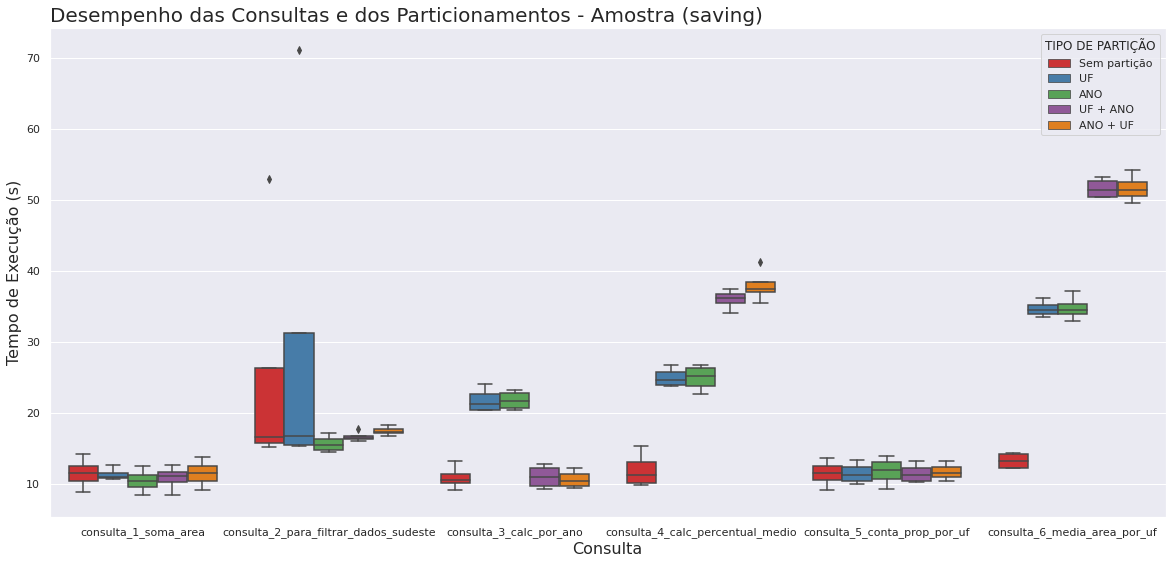

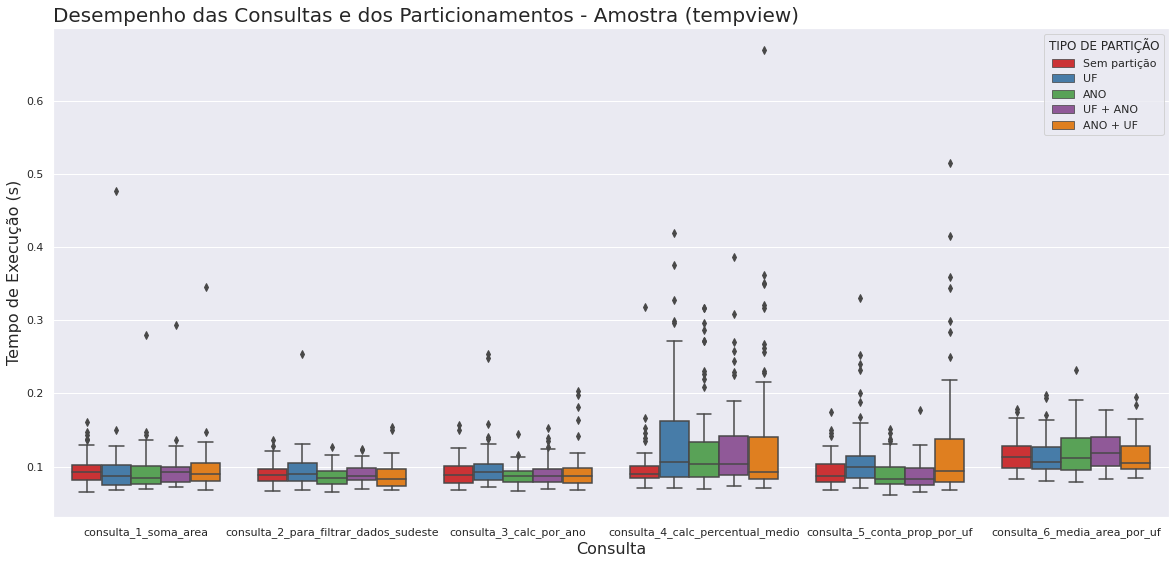

In [0]:
# SAMPLE - SAVING
gerar_grafico(tipo_tabela='sample', tipo_de_consultas='saving', tipo_de_grafico='boxplot')

# SAMPLE - TEMPVIEW
gerar_grafico(tipo_tabela='sample', tipo_de_consultas='tempview', tipo_de_grafico='boxplot')

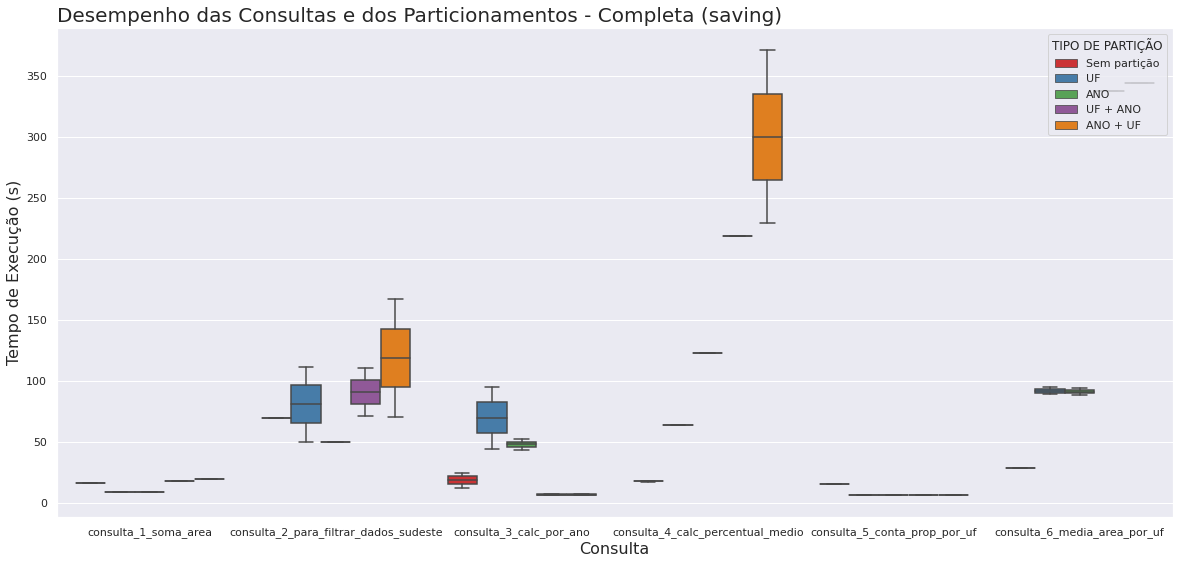

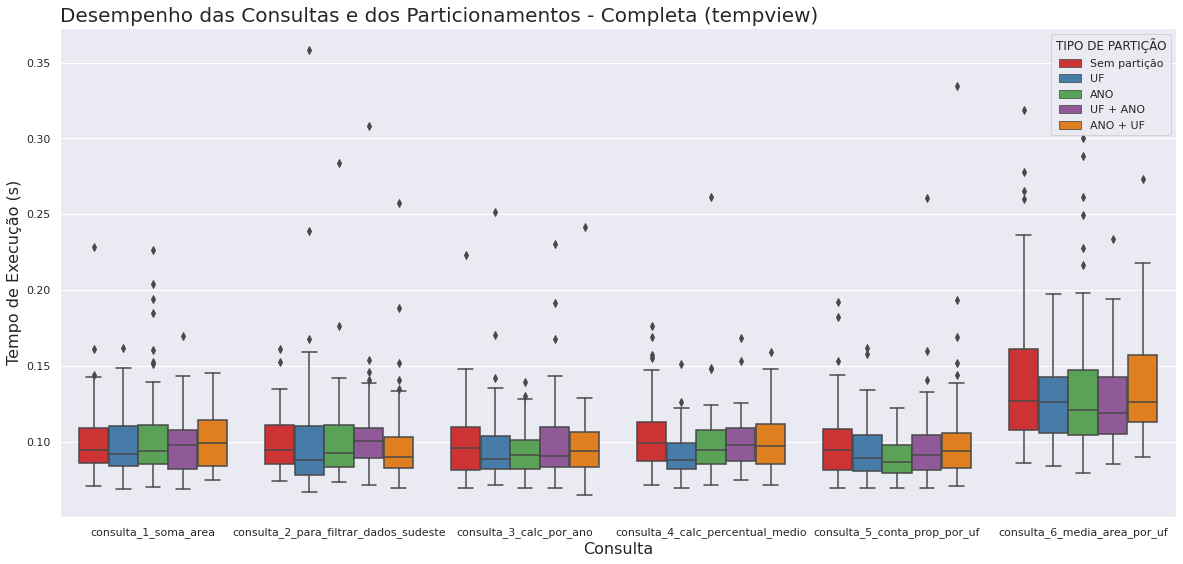

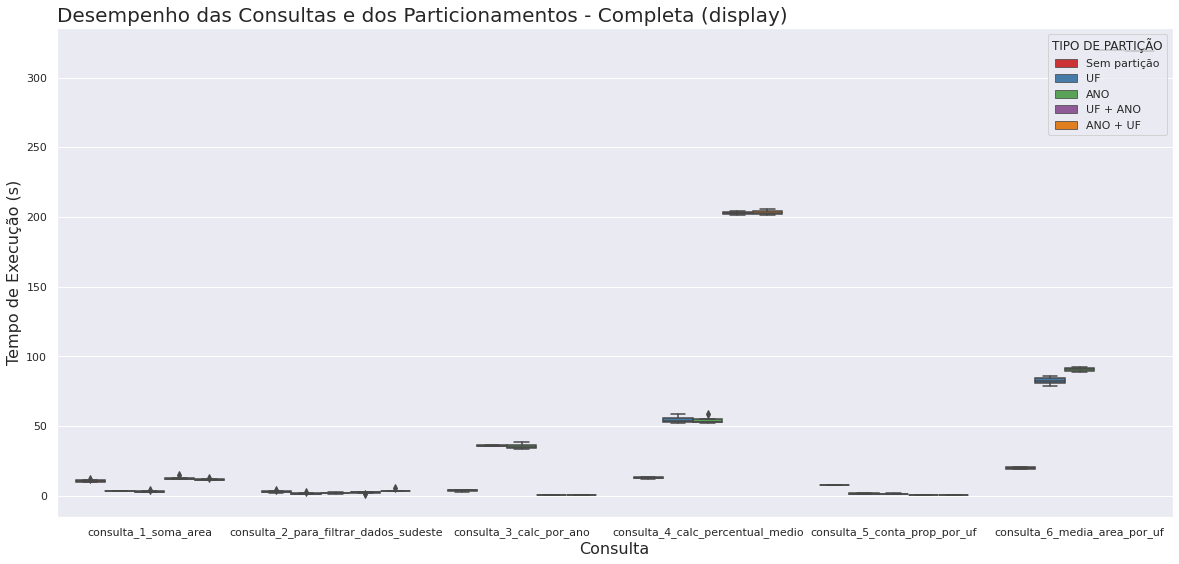

In [0]:
# TOTAL - SAVING
gerar_grafico(tipo_tabela='total', tipo_de_consultas='saving', tipo_de_grafico='boxplot')

# TOTAL - TEMPVIEW
gerar_grafico(tipo_tabela='total', tipo_de_consultas='tempview', tipo_de_grafico='boxplot')

# TOTAL - DISPLAY
gerar_grafico(tipo_tabela='total', tipo_de_consultas='display', tipo_de_grafico='boxplot')



#### Avaliação do Tipo de Gráfico: Caixa ou Barras?

O gráfico de caixa (boxplot) traz muitas informações, como a medida central da mediana e uma representação gráfica da dispersão dos dados. Isso possibilita a análise mais profunda, considerando os riscos da variação do processamento. No entanto, este gráfico traz maior complexidade de compreensão devido à poluição gráfica de tantas informações.

O gráfico de barras traz somente a informação da média do tempo de execução, sendo mais direto na mensagem que deseja passar. Ele é mais fácil de compreensão e mais agradável de ser visto. No entanto, ele oculta muitas informações que podem ser observadas no outro tipo de gráfico.

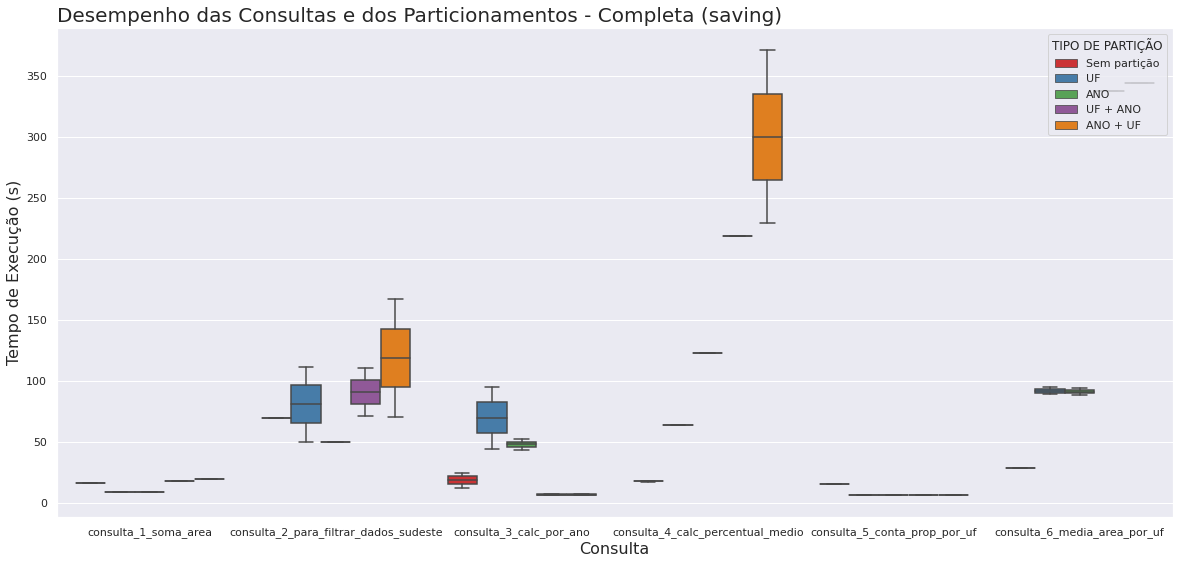

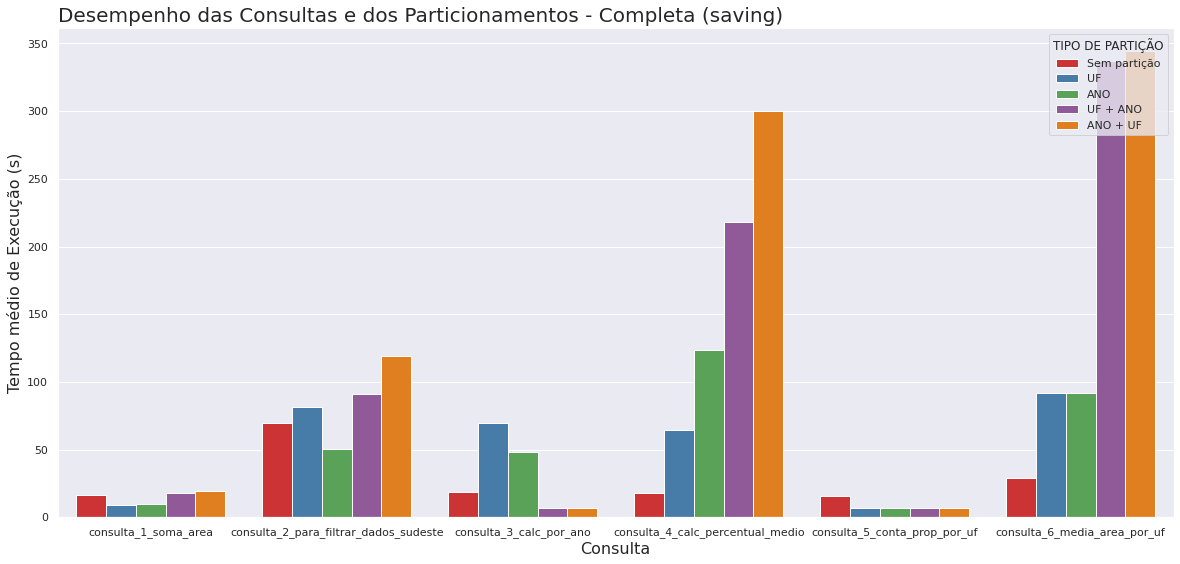

In [0]:
# TOTAL - SAVING - BOX
gerar_grafico(tipo_tabela='total', tipo_de_consultas='saving', tipo_de_grafico='boxplot')

# TOTAL - SAVING - BAR
gerar_grafico(tipo_tabela='total', tipo_de_consultas='saving', tipo_de_grafico='bar')

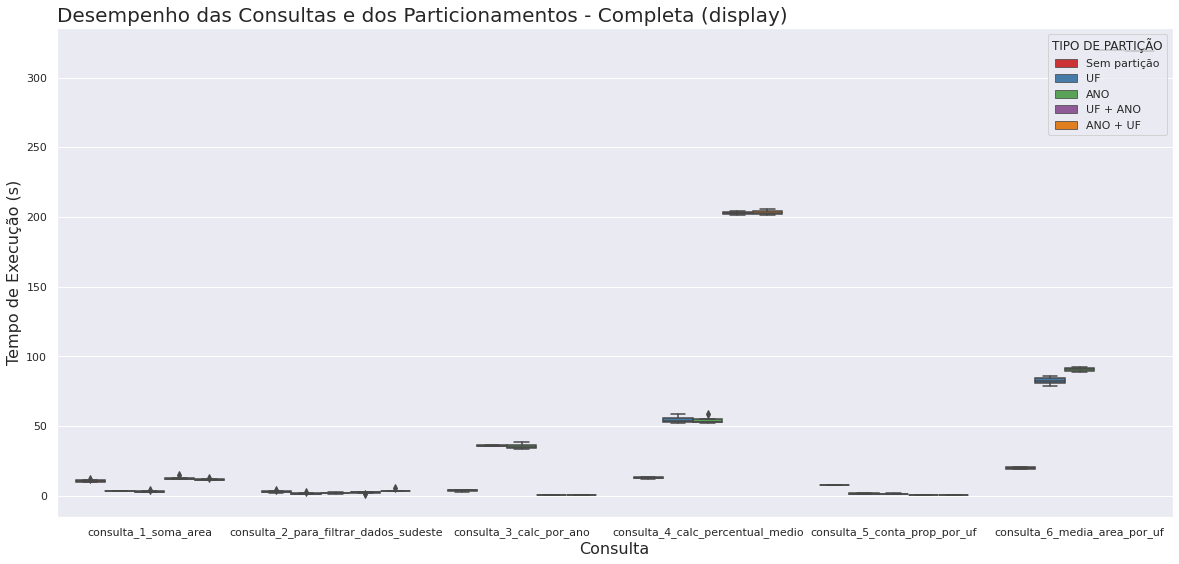

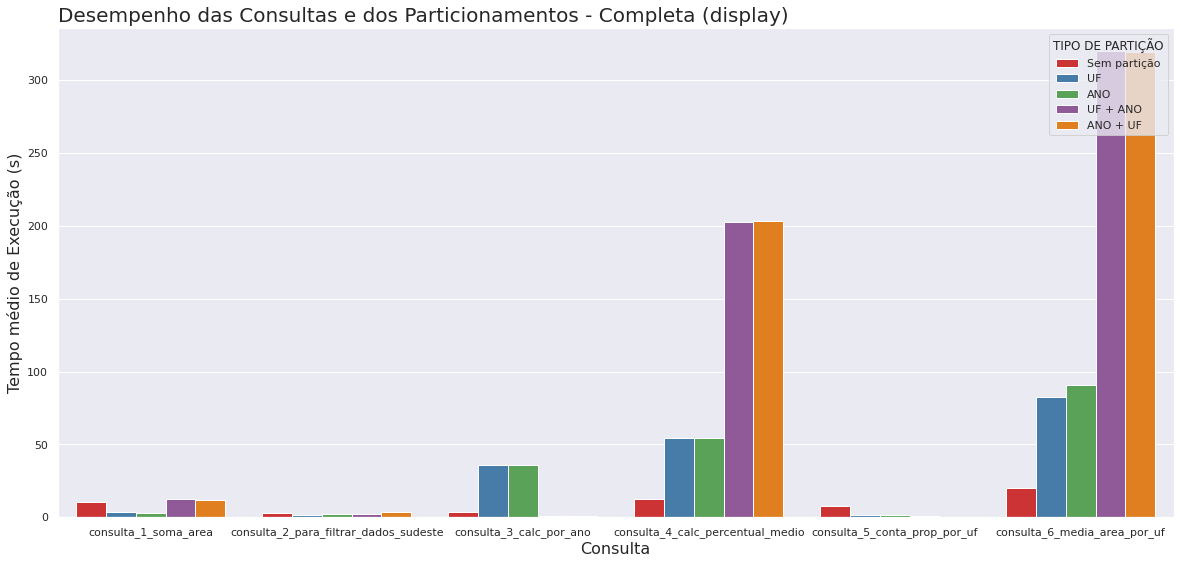

In [0]:
# TOTAL - DISPLAY
gerar_grafico(tipo_tabela='total', tipo_de_consultas='display', tipo_de_grafico='boxplot')

# TOTAL - DISPLAY - BARRAS
gerar_grafico(tipo_tabela='total', tipo_de_consultas='display', tipo_de_grafico='bar')


#### Avaliação entre Amostra e Base Completa

O uso de uma amostra permite a realização dos teste em até 1/7 do tempo que de execução da base completa. Isso multiplica nos diversos testes necessários (600 execuções para obtenção de medidas estatíticas) resulta em uma grande vantagem de ganho de tempo.

Os testes a seguir usam como base o modo de avaliação do desempenho a persistencia em um arquivo físico.

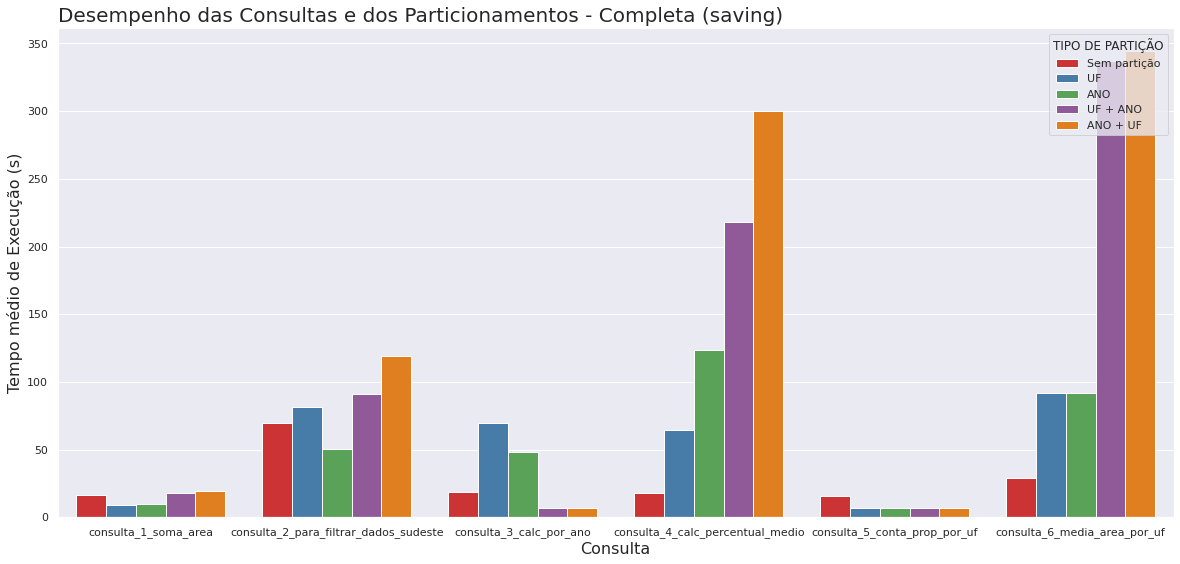

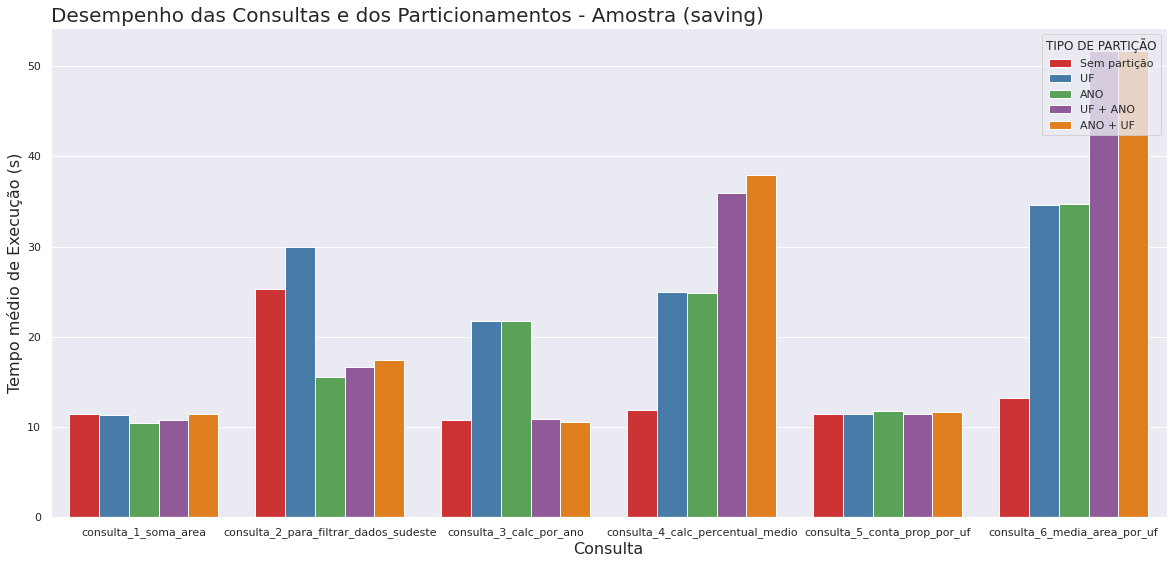

In [0]:
# TOTAL - SAVING
gerar_grafico(tipo_tabela='total', tipo_de_consultas='saving', tipo_de_grafico='bar')

# TOTAL - SAVING
gerar_grafico(tipo_tabela='sample', tipo_de_consultas='saving', tipo_de_grafico='bar')

### 3.5.3 Avaliação do Tipo de Particionamento

A maior parte dos testes, a base de dados particionada não teve um desempenho melhor do que a base não particionada. Inclusive, em alguns casos ela consumiu 7x mais tempo para executar a consulta do que a tabela armazenada de forma monolítica.

Tudo isso demonstra os cuidados que deve-se ter ao propor um particionamento de uma tabela. A simples implementação de uma técnica não resulta de forma determinística em resultados melhores.

Para compreender a causa do desempenho dos teste, alguns estudos sobre a distribuição dos dados nas particições foi realizado e apresentado a seguir.

In [0]:
# Criação de uma tabela temporária para acesso no SparkSQL
df_spark_treat_total.createOrReplaceTempView('data')

In [0]:
display(spark.sql('SELECT uf, count(*) FROM data GROUP BY uf ORDER BY uf'))

uf count(1) AC 45141 AL 114610 AM 73642 AP 10116 BA 1012499 CE 314866 DF 17339 ES 108849 GO 199690 MA 273642 MG 989446 MS 79914 MT 170205 PA 279598 PB 170851 PE 339371 PI 255052 PR 496164 RJ 58923 RN 89357 RO 147287 RR 22687 RS 606454 SC 374918 SE 94418 SP 408528 TO 85537

Databricks visualization. Run in Databricks to view.

In [0]:
display(spark.sql('SELECT ano, count(*) FROM data GROUP BY ano ORDER BY ano'))

ano count(1) null 12 2013 743 2014 227468 2015 1240178 2016 1828786 2017 794779 2018 724856 2019 746570 2020 463322 2021 443942 2022 368448

Databricks visualization. Run in Databricks to view.

In [0]:
display(spark.sql('SELECT concat(string(ano), uf) as ano_uf, count(*) FROM data GROUP BY ano, uf ORDER BY ano, uf'))

ano_uf count(1) null 4 null 1 null 6 null 1 2013ES 521 2013SP 222 2014AC 15007 2014AL 32 2014AM 1401 2014AP 86 2014BA 3296 2014CE 97 2014DF 728 2014ES 3542 2014GO 9077 2014MA 2280 2014MG 45811 2014MS 391 2014MT 45059 2014PB 175 2014PE 245 2014PI 102 2014PR 19579 2014RJ 1915 2014RN 403 2014RR 476 2014RS 659 2014SC 38817 2014SE 1552 2014SP 33604 2014TO 3134 2015AC 7680 2015AL 3762 2015AM 9109 2015AP 692 2015BA 22923 2015CE 4348 2015DF 1400 2015ES 8627 2015GO 48043 2015MA 19255 2015MG 254359 2015MS 8113 2015MT 34469 2015PA 113940 2015PB 6987 2015PE 13010 2015PI 3756 2015PR 170928 2015RJ 12922 2015RN 4172 2015RO 49567 2015RR 2056 2015RS 76070 2015SC 155249 2015SE 6174 2015SP 187858 2015TO 14709 2016AC 8788 2016AL 38925 2016AM 11782 2016AP 1456 2016BA 72024 2016CE 36888 2016DF 5538 2016ES 38064 2016GO 57647 2016MA 30831 2016MG 291874 2016MS 28540 2016MT 28139 2016PA 42014 2016PB 52396 2016PE 129195 2016PI 79145 2016PR 170127 2016RJ 20975 2016RN 33104 2016RO 41017 2016RR 2416 2016RS 381038 2016SC 95903 2016SE 25393 2016SP 87400 2016TO 18167 2017AC 1392 2017AL 10310 2017AM 11150 2017AP 1727 2017BA 300569 2017CE 25574 2017DF 4141 2017ES 12189 2017GO 17364 2017MA 15946 2017MG 66165 2017MS 19497 2017MT 7924 2017PA 19088 2017PB 30765 2017PE 42627 2017PI 32433 2017PR 34406 2017RJ 5763 2017RN 8863 2017RO 11072 2017RR 1229 2017RS 51205 2017SC 18011 2017SE 10811 2017SP 21673 2017TO 12885 2018AC 1849 2018AL 14992 2018AM 13922 2018AP 1374 2018BA 212455 2018CE 101851 2018DF 1444 2018ES 21714 2018GO 15540 2018MA 14525 2018MG 61258 2018MS 7415 2018MT 14522 2018PA 17793 2018PB 22458 2018PE 31607 2018PI 21995 2018PR 24858 2018RJ 5212 2018RN 7733 2018RO 11371 2018RR 2577 2018RS 31006 2018SC 15832 2018SE 9866 2018SP 19594 2018TO 20093 2019AC 1660 2019AL 20363 2019AM 7415 2019AP 1028 2019BA 160908 2019CE 80451 2019DF 1043 2019ES 8660 2019GO 18046 2019MA 57615 2019MG 90511 2019MS 5029 2019MT 12002 2019PA 16601 2019PB 24809 2019PE 42263 2019PI 53636 2019PR 27509 2019RJ 4385 2019RN 15497 2019RO 9211 2019RR 1554 2019RS 28535 2019SC 17331 2019SE 17026 2019SP 18626 2019TO 4856 2020AC 2108 2020AL 10488 2020AM 5926 2020AP 960 2020BA 93567 2020CE 20991 2020DF 801 2020ES 6180 2020GO 12104 2020MA 56446 2020MG 62454 2020MS 6154 2020MT 10006 2020PA 17698 2020PB 12279 2020PE 28954 2020PI 26881 2020PR 17435 2020RJ 2692 2020RN 7505 2020RO 8074 2020RR 2740 2020RS 13121 2020SC 10550 2020SE 9052 2020SP 14466 2020TO 3690 2021AC 2840 2021AL 8654 2021AM 6570 2021AP 1207 2021BA 88320 2021CE 18460 2021DF 1202 2021ES 4930 2021GO 11995 2021MA 48432 2021MG 58682 2021MS 2611 2021MT 9803 2021PA 26867 2021PB 11528 2021PE 28231 2021PI 21303 2021PR 16955 2021RJ 2813 2021RN 6318 2021RO 9099 2021RR 7556 2021RS 12317 2021SC 12224 2021SE 7564 2021SP 13049 2021TO 4412 2022AC 3817 2022AL 7084 2022AM 6367 2022AP 1586 2022BA 58437 2022CE 26206 2022DF 1042 2022ES 4422 2022GO 9870 2022MA 28312 2022MG 58332 2022MS 2164 2022MT 8281 2022PA 25597 2022PB 9454 2022PE 23238 2022PI 15801 2022PR 14361 2022RJ 2246 2022RN 5762 2022RO 7876 2022RR 2083 2022RS 12503 2022SC 11000 2022SE 6980 2022SP 12036 2022TO 3591

Databricks visualization. Run in Databricks to view.

In [0]:
display(spark.sql('''
    SELECT ano, mean(qtd) as media, std(qtd) as std
    FROM  (SELECT ano, count(*) as qtd FROM data GROUP BY ano ORDER BY ano) as t1
    GROUP BY ano
    '''))

ano media std null 12.0 NaN 2013 743.0 NaN 2014 227468.0 NaN 2015 1240178.0 NaN 2016 1828786.0 NaN 2017 794779.0 NaN 2018 724856.0 NaN 2019 746570.0 NaN 2020 463322.0 NaN 2021 443942.0 NaN 2022 368448.0 NaN


Analisando graficamente a distribuição de cada particição pode-se observar um grande desbalanceamento entre elas. O campo `UF` possui grande variação entre a quantidade de elementos em cada classe. O mesmo ocorre para o campo de `ano`. Quando se junta ambos os campos, potecializa-se o desbalanceamento entre as 